- 保监会 相关性模型 2 训练 

# 基本设置

In [1]:
##load packages, needed
# encoding=utf-8

import jieba
import sys
import re
import time
import string
from sklearn import feature_extraction
from sklearn.pipeline import Pipeline,FeatureUnion

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2,mutual_info_classif,f_classif 

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn import metrics

from sklearn.base import BaseEstimator, TransformerMixin
from collections import defaultdict

import joblib
%matplotlib inline
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

## 一些函数

In [10]:
class StatsFeatures(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def getcnt(self,x): 
        words = x.split()
        return len(list(set(words)))
    
    def transform(self, X):
        data = []
        for x in X:
            words = x.split()
            if len(words) == 0:
                length  = 1
            else :
                length = len(words)
            data.append([len(x),self.getcnt(x),self.getcnt(x)/length])            
        return data

In [3]:
def title_content_label(filepath):
    title = []
    filename = filepath + 'titles.txt'
    fid = open(filename, "r+", encoding='UTF-8')
    for f in fid:
        title.append(f.strip().replace('\n', ''))
    fid.close()
    print('title num: ', len(title))
    print(title[:2])

    content = []
    filename = filepath + 'contents.txt'
    fid = open(filename, "r+", encoding='UTF-8')
    for f in fid:
        content.append(f.strip().replace('\n', ''))
    fid.close()
    print('content num: ', len(content))
    # content[:2]

    title_content = [t + ' ' + c for t,c in zip(title, content)]
    print('title_content num: ', len(title_content))

    label = []
    filename = filepath + 'labels.txt'
    fid = open(filename, "r+", encoding='UTF-8')
    for f in fid:
        label.append(f.strip().replace('\n', ''))
    fid.close()
    print('label num: ', len(label))
    print(label[:5])
    
    return title_content, label

In [4]:
def cal_kfold(title_content, label, pipeline, raw_folder, filename):
    from sklearn.model_selection import KFold
    import numpy as np

    data_raw = pd.read_excel('%s/corpus/title_content_label.xlsx'%raw_folder)
    raw_title = np.array(data_raw['title'])
    raw_content = np.array(data_raw['content'])
    print('data_raw: ', data_raw.shape)

    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    title_content = np.array(title_content)
    label = np.array(label)
    
    kfold_res = {'raw_title':[], 'raw_content':[], 'label':[], 
             'predict_label':[], 'title_content':[], 'predict_proba':[]}

    num = 0
    for train_index , test_index in kf.split(title_content):
        print('---- %s'%(num+1))
        X_train,X_test = title_content[train_index], title_content[test_index]
        y_train,y_test = label[train_index], label[test_index]
        
        pipeline.fit(X_train, y_train)
        print(pipeline.score(X_train, y_train))    

        y_pred_class = pipeline.predict(X_test)
        print('accuracy_score: ', metrics.accuracy_score(y_test, y_pred_class)) # 指所有分类正确的百分比
        print(metrics.classification_report(y_test, y_pred_class))
        print('confusion_matrix: ')
        print( metrics.confusion_matrix(y_test, y_pred_class))   
        
        y_pred_prob = pipeline.predict_proba(X_test)

        kfold_res['raw_title'] += list(raw_title[test_index])
        kfold_res['raw_content'] += list(raw_content[test_index])
        kfold_res['title_content'] += list(X_test)
        kfold_res['label'] += [class_name_dict[i] for i in y_test]
        kfold_res['predict_label'] += [class_name_dict[i] for i in y_pred_class]
        kfold_res['predict_proba'] += list(y_pred_prob.max(axis = 1))
    
        num += 1
        
    kfold_result = pd.DataFrame.from_dict(kfold_res, orient = 'index').T
    kfold_result['R_W'] = kfold_result.apply(lambda x: 'Right' if x['label'] == x['predict_label'] else 'Wrong', axis = 1)
    print('kfold_result: ', kfold_result.shape)
    
    with pd.ExcelWriter('%s/corpus/%s'%(raw_folder, filename)) as writer:
        for label in kfold_result['label'].unique():
            tmp_data = kfold_result[kfold_result['label'] == label]
            tmp_data.to_excel(writer, label, index = False)
        writer.save()

In [5]:
def plot_class_proba(y_pred_class, y_pred_prob, label_dic):
    import seaborn as sns
    import matplotlib.pyplot as plt

    sel_data = pd.DataFrame()
    sel_data['predict_label'] = y_pred_class
    sel_data['predict_proba'] = y_pred_prob
    sel_data['label'] = y_test

    # label_dic={'监管':1,'行业':2,'产品销售':3,'资本市场':4,'公司内部管理':5,'消费服务':6,'其他相关报道':7,'噪音':8}
    # sel_data['predict_label'] = sel_data['predict_label'].apply(lambda x:label_dic[x])
    g = sns.FacetGrid(sel_data, col="predict_label", col_wrap=4, sharex=False)
    g.map(plt.hist, "predict_proba", bins = 10)

    sel_data['proba'] = sel_data['predict_proba'].apply(lambda x:round(x, 1))
    sel_data_stat = sel_data.groupby(['predict_label', 'proba'])['predict_proba'].count().unstack().fillna(0)
    sel_data_stat['sum'] = sel_data_stat.sum(axis = 1)
    sel_data_stat.loc['sum'] = sel_data_stat.sum(axis = 0)
    return sel_data_stat

# 网信办--行业分类

## 导入数据

In [29]:
cac_filepath_class = 'industry_result/corpus/'
title_content, label = title_content_label(cac_filepath_class)

title num:  15992
['club mourinho insists manchester united future', 'ronaldo insists real coach lopetegui']
content num:  15992
title_content num:  15992
label num:  15992
['体育', '体育', '体育', '体育', '体育']


In [30]:
label_dic={'体育': 1, '军事': 2, '政治': 3, '文化': 4, '法制': 5, '社会': 6, '科技': 7, '经贸': 8}
class_name_dict = {v: k for k, v in label_dic.items()}
class_name_dict

{1: '体育', 2: '军事', 3: '政治', 4: '文化', 5: '法制', 6: '社会', 7: '科技', 8: '经贸'}

In [31]:
label = [label_dic[l] for l in label]
label[:5]

[1, 1, 1, 1, 1]

In [32]:
X_train, X_test, y_train, y_test = train_test_split(title_content, label, test_size=0.3, random_state=42)
print('训练集：',len(y_train))
print('训练集-各类数量：',Counter(y_train))
print('测试集：',len(y_test))
print('测试集-各类数量：',Counter(y_test))

训练集： 11194
训练集-各类数量： Counter({7: 1434, 6: 1419, 4: 1418, 1: 1414, 8: 1396, 2: 1392, 3: 1364, 5: 1357})
测试集： 4798
测试集-各类数量： Counter({5: 642, 3: 635, 2: 607, 8: 603, 1: 585, 4: 581, 6: 580, 7: 565})


## train-test

In [11]:
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('tf_idf', Pipeline([
            ('counts', CountVectorizer()),
            ('tf_idf', TfidfTransformer()),
            ('chi', SelectKBest(chi2, k=20000))
        ])),
        ('len_stats', StatsFeatures())
    ])),
    ('classifier', XGBClassifier(max_depth=7,objective='multi:softmax', num_class=8))
])

pipeline.fit(X_train, y_train)
print(pipeline.score(X_train, y_train))
pipeline

0.9618545649455065


Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('tf_idf', Pipeline(memory=None,
     steps=[('counts', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0...tate=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1))])

In [12]:
y_pred_class = pipeline.predict(X_test)
print('accuracy_score: ', metrics.accuracy_score(y_test, y_pred_class)) # 指所有分类正确的百分比
print(metrics.classification_report(y_test, y_pred_class))
print('confusion_matrix: ')
print( metrics.confusion_matrix(y_test, y_pred_class))

accuracy_score:  0.7653188828678616
             precision    recall  f1-score   support

          1       0.90      0.92      0.91       585
          2       0.87      0.90      0.88       607
          3       0.73      0.69      0.71       635
          4       0.81      0.82      0.81       581
          5       0.73      0.72      0.73       642
          6       0.55      0.53      0.54       580
          7       0.80      0.78      0.79       565
          8       0.74      0.78      0.76       603

avg / total       0.76      0.77      0.76      4798

confusion_matrix: 
[[538   2   5   2  13  20   3   2]
 [  6 544  14   8  10  16   4   5]
 [  8  33 439   8  50  45   5  47]
 [  9   4  13 474   7  44  16  14]
 [  6  16  61  18 463  45  11  22]
 [ 15  17  45  52  62 308  37  44]
 [  6   4   9  14  12  49 438  33]
 [ 13   3  19  12  18  36  34 468]]


## 概率结果

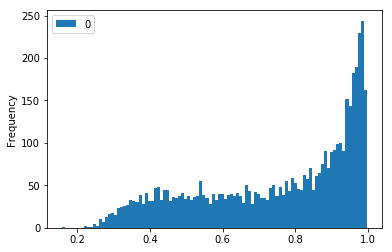

In [13]:
y_pred_prob = pipeline.predict_proba(X_test)
pd.DataFrame(y_pred_prob.max(axis = 1)).plot.hist(bins = 100)

proba,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,sum
predict_label,,,,,,,,,,
1,0.0,8.0,22.0,22.0,30.0,36.0,52.0,155.0,276.0,601.0
2,0.0,7.0,11.0,17.0,25.0,30.0,52.0,138.0,343.0,623.0
3,1.0,24.0,60.0,54.0,75.0,87.0,87.0,137.0,80.0,605.0
4,0.0,12.0,35.0,32.0,40.0,49.0,82.0,194.0,144.0,588.0
5,0.0,21.0,45.0,82.0,84.0,87.0,119.0,162.0,35.0,635.0
6,3.0,75.0,145.0,116.0,100.0,62.0,51.0,11.0,0.0,563.0
7,3.0,20.0,51.0,50.0,42.0,67.0,75.0,133.0,107.0,548.0
8,1.0,44.0,69.0,78.0,52.0,50.0,98.0,145.0,98.0,635.0
sum,8.0,211.0,438.0,451.0,448.0,468.0,616.0,1075.0,1083.0,4798.0


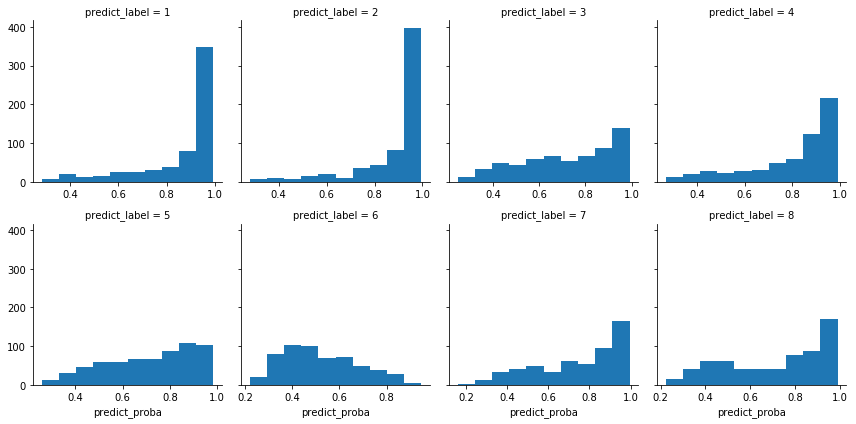

In [14]:
sel_data_stat = plot_class_proba(y_pred_class, y_pred_prob.max(axis = 1), label_dic)
sel_data_stat

## KFold

In [33]:
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('tf_idf', Pipeline([
            ('counts', CountVectorizer()),
            ('tf_idf', TfidfTransformer()),
            ('chi', SelectKBest(chi2, k=20000))
        ])),
        ('len_stats', StatsFeatures())
    ])),
    ('classifier', XGBClassifier(max_depth=7,objective='multi:softmax', num_class=8))
])

filename = 'cac_industry_label_proba_20181025.xlsx'
cal_kfold(title_content, label, pipeline, 'industry_result', filename)

data_raw:  (15992, 5)
---- 1
0.9521613382318456
accuracy_score:  0.7686777117849328
             precision    recall  f1-score   support

          1       0.93      0.90      0.91       398
          2       0.89      0.88      0.88       371
          3       0.71      0.74      0.72       407
          4       0.82      0.83      0.82       385
          5       0.75      0.78      0.76       421
          6       0.55      0.51      0.53       416
          7       0.79      0.74      0.77       395
          8       0.74      0.78      0.76       406

avg / total       0.77      0.77      0.77      3199

confusion_matrix: 
[[360   1   2   2   6  19   4   4]
 [  4 325  11   3   9   8   6   5]
 [  3  15 302   3  31  31   2  20]
 [  1   2   6 318   8  35  10   5]
 [  2   4  34  10 329  24   8  10]
 [ 10   9  42  41  41 214  27  32]
 [  4   6   9   9   5  32 294  36]
 [  5   2  21   3  11  27  20 317]]
---- 2
0.9542718674274994
accuracy_score:  0.7833698030634574
             precisio

## 模型保存

In [15]:
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('tf_idf', Pipeline([
            ('counts', CountVectorizer()),
            ('tf_idf', TfidfTransformer()),
            ('chi', SelectKBest(chi2, k=20000))
        ])),
        ('len_stats', StatsFeatures())
    ])),
    ('classifier', XGBClassifier(max_depth=7,objective='multi:softmax', num_class=8))
])

pipeline.fit(title_content, label)
print(pipeline.score(title_content, label))
pipeline

0.9405327663831916


Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('tf_idf', Pipeline(memory=None,
     steps=[('counts', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0...tate=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1))])

In [16]:
from sklearn.externals import joblib
joblib.dump(pipeline, "model/cac_industy_1026.pkl.z")  

['model/cac_industy_1026.pkl.z']

# 网信办--倾向性

## 导入数据

In [17]:
cac_filepath_class = 'tendency_result/corpus/'
title_content, label = title_content_label(cac_filepath_class)

title num:  7915
['shopping mall seek rodent', 'tonight']
content num:  7915
title_content num:  7915
label num:  7915
['中', '中', '中', '中', '中']


In [18]:
label_dic={'中': 0, '正': 1, '负': -1}
class_name_dict = {v: k for k, v in label_dic.items()}
class_name_dict

{-1: '负', 0: '中', 1: '正'}

In [19]:
label = [label_dic[l] for l in label]
label[:5]

[0, 0, 0, 0, 0]

In [20]:
X_train, X_test, y_train, y_test = train_test_split(title_content, label, test_size=0.3, random_state=42)
print('训练集：',len(y_train))
print('训练集-各类数量：',Counter(y_train))
print('测试集：',len(y_test))
print('测试集-各类数量：',Counter(y_test))

训练集： 5540
训练集-各类数量： Counter({-1: 2069, 0: 2031, 1: 1440})
测试集： 2375
测试集-各类数量： Counter({0: 911, -1: 897, 1: 567})


## train-test

In [41]:
# class StatsFeatures_tend(BaseEstimator, TransformerMixin):
    
#     def __init__(self):
#         pass

#     def fit(self, X, y=None):
#         return self

#     def getcnt(self,x): 
#         words = x.split()
#         return len(list(set(words)))
    
#     def transform(self, X):
#         data = []
#         for x in X:
#             words = x.split()
#             if len(words) == 0:
#                 length  = 1
#             else :
#                 length = len(words)
#             data.append([len(x),self.getcnt(x),self.getcnt(x)/length])            
#         return data

In [21]:
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('tf_idf', Pipeline([
            ('counts', CountVectorizer(max_df=0.95, min_df=2)),
            ('tf_idf', TfidfTransformer()),
            ('chi', SelectKBest(chi2, k=20000))
        ])),
        ('len_stats', StatsFeatures())
    ])),
    ('classifier', XGBClassifier(max_depth=7,objective='multi:softmax', num_class=3))
])

pipeline.fit(X_train, y_train)
print(pipeline.score(X_train, y_train))
pipeline

0.9238267148014441


Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('tf_idf', Pipeline(memory=None,
     steps=[('counts', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.9...tate=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1))])

In [22]:
y_pred_class = pipeline.predict(X_test)
print('accuracy_score: ', metrics.accuracy_score(y_test, y_pred_class)) # 指所有分类正确的百分比
print(metrics.classification_report(y_test, y_pred_class))
print('confusion_matrix: ')
print( metrics.confusion_matrix(y_test, y_pred_class))

accuracy_score:  0.720421052631579
             precision    recall  f1-score   support

         -1       0.76      0.76      0.76       897
          0       0.68      0.76      0.72       911
          1       0.74      0.60      0.66       567

avg / total       0.72      0.72      0.72      2375

confusion_matrix: 
[[680 171  46]
 [147 688  76]
 [ 70 154 343]]


## 概率结果

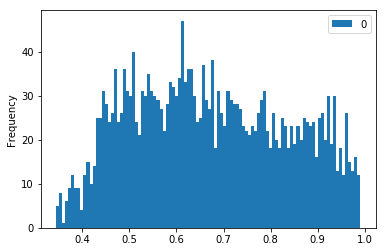

In [23]:
y_pred_prob = pipeline.predict_proba(X_test)
pd.DataFrame(y_pred_prob.max(axis = 1)).plot.hist(bins = 100)

proba,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,sum
predict_label,,,,,,,,,
-1,3.0,47.0,126.0,121.0,129.0,170.0,214.0,87.0,897.0
0,1.0,102.0,262.0,284.0,230.0,112.0,22.0,0.0,1013.0
1,1.0,48.0,69.0,81.0,70.0,74.0,107.0,15.0,465.0
sum,5.0,197.0,457.0,486.0,429.0,356.0,343.0,102.0,2375.0


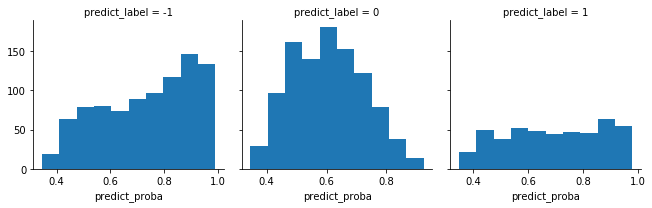

In [24]:
sel_data_stat = plot_class_proba(y_pred_class, y_pred_prob.max(axis = 1), label_dic)
sel_data_stat

## KFold

In [27]:
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('tf_idf', Pipeline([
            ('counts', CountVectorizer()),
            ('tf_idf', TfidfTransformer()),
            ('chi', SelectKBest(chi2, k=20000))
        ])),
        ('len_stats', StatsFeatures())
    ])),
    ('classifier', XGBClassifier(max_depth=7,objective='multi:softmax', num_class=3))
])

filename = 'cac_tendency_label_proba_20181026.xlsx'
cal_kfold(title_content, label, pipeline, 'tendency_result', filename)

data_raw:  (7915, 5)
---- 1
0.9134554643082754
accuracy_score:  0.7182564750473784
             precision    recall  f1-score   support

         -1       0.77      0.75      0.76       593
          0       0.66      0.77      0.71       596
          1       0.76      0.60      0.67       394

avg / total       0.72      0.72      0.72      1583

confusion_matrix: 
[[446 120  27]
 [ 93 456  47]
 [ 40 119 235]]
---- 2
0.9164560960202148
accuracy_score:  0.7195198989260897
             precision    recall  f1-score   support

         -1       0.79      0.72      0.76       588
          0       0.66      0.79      0.72       600
          1       0.73      0.61      0.66       395

avg / total       0.73      0.72      0.72      1583

confusion_matrix: 
[[426 127  35]
 [ 73 473  54]
 [ 39 116 240]]
---- 3
0.9148768161718257
accuracy_score:  0.7144662034112444
             precision    recall  f1-score   support

         -1       0.78      0.76      0.77       580
          0       0.

## 模型保存

In [25]:
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('tf_idf', Pipeline([
            ('counts', CountVectorizer()),
            ('tf_idf', TfidfTransformer()),
            ('chi', SelectKBest(chi2, k=20000))
        ])),
        ('len_stats', StatsFeatures())
    ])),
    ('classifier', XGBClassifier(max_depth=7,objective='multi:softmax', num_class=3))
])

pipeline.fit(title_content, label)
print(pipeline.score(title_content, label))
pipeline

0.9020846493998737


Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('tf_idf', Pipeline(memory=None,
     steps=[('counts', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0...tate=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1))])

In [26]:
from sklearn.externals import joblib
joblib.dump(pipeline, "model/cac_tendency_1026.pkl.z")  

['model/cac_tendency_1026.pkl.z']

# 保存本文件

In [56]:
if 0:
    import datetime as dt
    
    def output_HTML(read_file, output_file):
        from nbconvert import HTMLExporter
        import codecs
        import nbformat
        exporter = HTMLExporter()
        # read_file is '.ipynb', output_file is '.html'
        output_notebook = nbformat.read(read_file, as_version=4)
        output, resources = exporter.from_notebook_node(output_notebook)
        codecs.open(output_file, 'w', encoding='utf-8').write(output)

    html_file_folder = 'html_files'
    if not os.path.exists(html_file_folder):
        os.makedirs(html_file_folder)

    today = dt.datetime.now().strftime('%Y%m%d')
    current_file = 'circ_cor_model_2_train.ipynb'
    output_file = 'html_files\%s_%s.html'%(os.path.splitext(current_file)[0], today)
    output_HTML(current_file, output_file)